In [1]:
# Manipulação de dados
import duckdb
import pandas as pd

# Tratamento de dados
from scipy import stats
import numpy as np

# Visualização
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns

# Algoritmos
pd.set_option('display.max_columns',None)
ouro_db = duckdb.connect('ouro_db')
modelling_db = duckdb.connect(database='modelling_db')
final_db = duckdb.connect(database='final_db')

# EDA

## Qtd Medições por Estações

In [2]:
# Mantendo apenas as estações que possuem pelo menos n dias de medição válidos.

df_estacoes_count = modelling_db.execute(
"""
SELECT
    id_estacao
    ,COUNT(*) AS count_rows
FROM abt_estacoes_3_vizinhas
GROUP BY
    id_estacao
ORDER BY
    COUNT(*) DESC
""").fetch_df()

In [3]:
n_min_medicoes_necessarias = 365

n_estacoes_validas = len(df_estacoes_count.loc[df_estacoes_count['count_rows']>=n_min_medicoes_necessarias])
n_estacoes_total = len(df_estacoes_count)

n_medicoes_validas = df_estacoes_count.loc[df_estacoes_count['count_rows']>=n_min_medicoes_necessarias,'count_rows'].sum()
n_medicoes_total = df_estacoes_count['count_rows'].sum()
                                    
print(f"Número de estações com pelo menos {n_min_medicoes_necessarias} medições: {n_estacoes_validas}/{n_estacoes_total} ({n_estacoes_validas*100/n_estacoes_total:.2f}%)")
print(f"Total de registros mantidos no conjunto de dados: {n_medicoes_validas:,}/{n_medicoes_total:,} ({n_medicoes_validas*100/n_medicoes_total:.2f}%)")

Número de estações com pelo menos 365 medições: 3990/4455 (89.56%)
Total de registros mantidos no conjunto de dados: 18,145,973/18,194,966 (99.73%)


<Figure size 640x480 with 0 Axes>

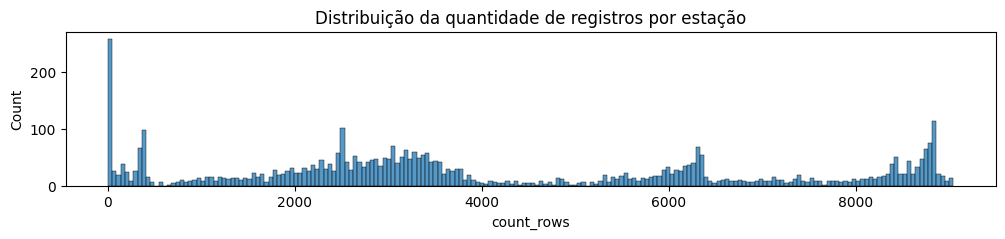

In [4]:
plt.clf()
fig = plt.figure(figsize=(12,2))
sns.histplot(df_estacoes_count['count_rows'],bins=200)
plt.title("Distribuição da quantidade de registros por estação")
plt.show()

<Figure size 640x480 with 0 Axes>

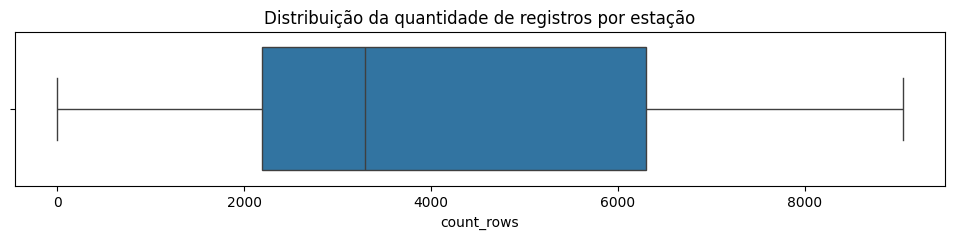

In [5]:
plt.clf()
fig = plt.figure(figsize=(12,2))
sns.boxplot(df_estacoes_count['count_rows'],orient='y')
plt.title("Distribuição da quantidade de registros por estação")
plt.show()

## Início de estações

In [6]:
df_precipitacao_validas = modelling_db.execute(
"""
WITH estacoes_validas AS (
SELECT
    id_estacao
FROM abt_estacoes_3_vizinhas
GROUP BY
    id_estacao
HAVING
    COUNT(*)>365
)
SELECT 
    abt.id_estacao
    ,abt.dt_medicao
    ,YEAR(abt.dt_medicao) AS dt_medicao_ano
    ,CAST(STRFTIME(DATE_TRUNC('MONTH', dt_medicao), '%Y%m') AS INT) AS dt_medicao_trunc
    ,abt.vl_precipitacao
FROM abt_estacoes_3_vizinhas AS abt
INNER JOIN estacoes_validas
    ON abt.id_estacao = estacoes_validas.id_estacao
""").fetch_df()

<Figure size 640x480 with 0 Axes>

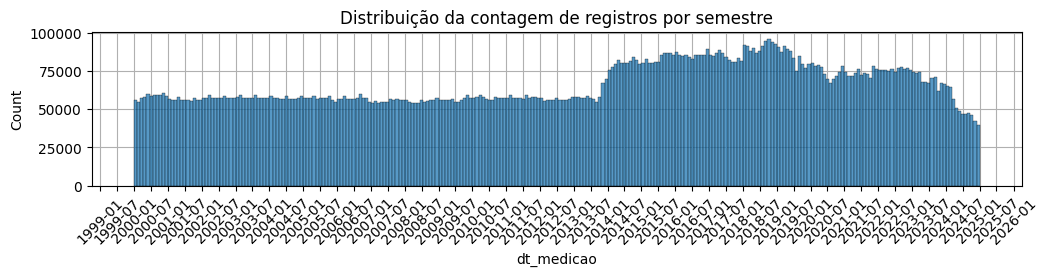

In [7]:
plt.clf()
fig = plt.figure(figsize=(12,2))
plt.grid()
g = sns.histplot(df_precipitacao_validas.loc[df_precipitacao_validas['dt_medicao_ano']>=2000,'dt_medicao'])
g.xaxis.set_major_locator(mdates.MonthLocator(bymonth=(1, 7)))
plt.xticks(rotation=45)
plt.title("Distribuição da contagem de registros por semestre")
g.set_axisbelow(True)

In [8]:
df_estacoes_por_ano_inicio = ouro_db.execute(
"""
SELECT DISTINCT
    YEAR(dt_inicio_dados_variavel) AS ano_inicio_precipitacao
    ,COUNT(DISTINCT id_estacao) AS count_novas_estacoes
    ,COUNT(DISTINCT nm_instituicao) AS count_instituicoes
FROM dim_estacoes
WHERE 1=1
    AND dim_estacoes.nm_variavel = 'precipitacao'
    AND YEAR(dt_inicio_dados_variavel)>=2000
GROUP BY
    YEAR(dt_inicio_dados_variavel)
ORDER BY
    ano_inicio_precipitacao
""").fetch_df()

<Figure size 640x480 with 0 Axes>

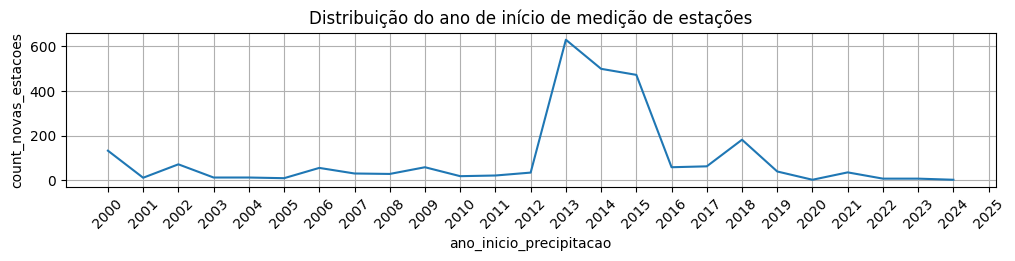

In [9]:
plt.clf()
fig = plt.figure(figsize=(12,2))

g = sns.lineplot(df_estacoes_por_ano_inicio,x='ano_inicio_precipitacao',y='count_novas_estacoes')

plt.grid()
g.set_axisbelow(True)

plt.xticks(ticks=range(2000,2026))
plt.xticks(rotation=45)

plt.title("Distribuição do ano de início de medição de estações")
plt.show()

In [10]:
df_instituicoes_2013 = ouro_db.execute(
"""
SELECT DISTINCT
    nm_instituicao
    ,COUNT(DISTINCT id_estacao) AS count_estacoes
FROM dim_estacoes
WHERE 1=1
    AND nm_variavel = 'precipitacao'
    AND YEAR(dt_inicio_dados_variavel)=2013
GROUP BY
    nm_instituicao
ORDER BY
    count_estacoes DESC
""").fetch_df()

<Figure size 640x480 with 0 Axes>

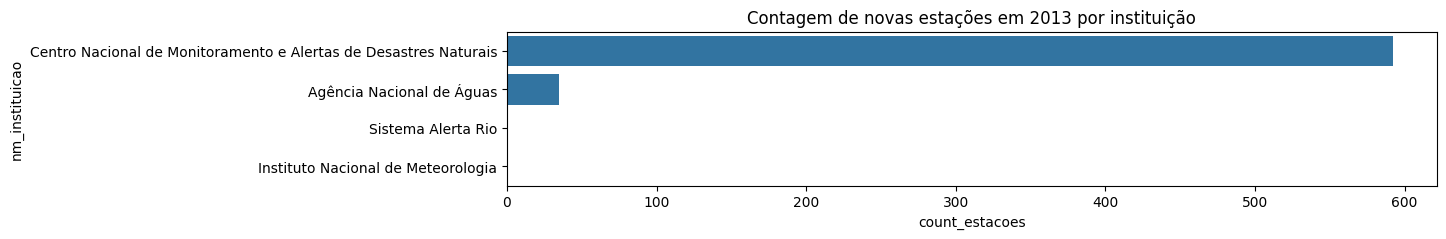

In [11]:
plt.clf()
fig = plt.figure(figsize=(12,2))
sns.barplot(df_instituicoes_2013,y='nm_instituicao',x='count_estacoes',orient='y')
plt.title("Contagem de novas estações em 2013 por instituição")
plt.show()

## Estações com latlon duplicados

In [12]:
list_estacoes_latlon_duplicados = ouro_db.execute(
"""
WITH duplicate_latlon AS (
SELECT
    latitude
    ,longitude
    ,COUNT(DISTINCT id_estacao) AS count_estacoes_distintas
FROM dim_estacoes
GROUP BY
    latitude
    ,longitude
HAVING count_estacoes_distintas > 1)
SELECT DISTINCT
    dim_estacoes.id_estacao
FROM dim_estacoes
INNER JOIN duplicate_latlon
    ON dim_estacoes.latitude = duplicate_latlon.latitude
    AND dim_estacoes.longitude = duplicate_latlon.longitude
WHERE 1=1
    AND dim_estacoes.nm_variavel = 'precipitacao'
ORDER BY
    dim_estacoes.latitude
    ,dim_estacoes.longitude
""").fetchall()

list_estacoes_latlon_duplicados = [x[0] for x in list_estacoes_latlon_duplicados]
str_estacoes_latlon_duplicados = ','.join([str(x) for x in list_estacoes_latlon_duplicados])

df_medicoes_por_latlon_data = modelling_db.execute(
f"""
SELECT
    latitude
    ,longitude
    ,dt_medicao
    ,COUNT(DISTINCT vl_precipitacao) AS count_precipitacao_distinctas
FROM abt_estacoes_3_vizinhas
WHERE 1=1
    AND id_estacao IN ({str_estacoes_latlon_duplicados})
GROUP BY
    latitude
    ,longitude
    ,dt_medicao
""").fetch_df()

df = modelling_db.execute(
f"""
WITH duplicatas_distintas AS (
SELECT
    latitude
    ,longitude
    ,dt_medicao
FROM abt_estacoes_3_vizinhas
WHERE 1=1
    AND id_estacao IN ({str_estacoes_latlon_duplicados})
GROUP BY
    latitude
    ,longitude
    ,dt_medicao
HAVING COUNT(DISTINCT vl_precipitacao) > 1
)
SELECT
    abt.id_estacao
    ,abt.latitude
    ,abt.longitude
    ,abt.dt_medicao
    ,abt.vl_precipitacao
FROM abt_estacoes_3_vizinhas AS abt
INNER JOIN duplicatas_distintas
    ON abt.latitude = duplicatas_distintas.latitude
    AND abt.longitude = duplicatas_distintas.longitude
    AND abt.dt_medicao = duplicatas_distintas.dt_medicao
""").fetch_df()

df = df.sort_values(['latitude', 'longitude', 'dt_medicao', 'id_estacao'])

df['rn'] = df.groupby(['latitude', 'longitude', 'dt_medicao']).cumcount() + 1

df2 = df[df['rn'].isin([1, 2])].copy()

df2['col_val'] = df2['rn'].map({1: 'vl_precipitacao_estacao_1', 2: 'vl_precipitacao_estacao_2'})

wide = df2.pivot_table(
    index=['latitude', 'longitude', 'dt_medicao'],
    columns='col_val',
    values='vl_precipitacao',
    aggfunc='first'
).reset_index()

df2['col_id'] = df2['rn'].map({1: 'id_estacao_1', 2: 'id_estacao_2'})
wide_ids = df2.pivot_table(
    index=['latitude', 'longitude', 'dt_medicao'],
    columns='col_id',
    values='id_estacao',
    aggfunc='first'
).reset_index()

wide = wide.merge(wide_ids, on=['latitude', 'longitude', 'dt_medicao'], how='left')
wide['diff'] = (wide['vl_precipitacao_estacao_1']-wide['vl_precipitacao_estacao_2']).abs()

In [13]:
print("Quantidade de medições em que as estações duplicadas registraram mesma precipitação")
print(f" > {df_medicoes_por_latlon_data['count_precipitacao_distinctas'].value_counts()[1]:,}")
print("Quantidade de medições em que as estações duplicadas NÃO registraram mesma precipitação")
print(f" > {df_medicoes_por_latlon_data['count_precipitacao_distinctas'].value_counts()[2]:,}")
print(f" > Dessas, {len(wide.loc[wide['diff']>=1]):,} medições possuíram diferença de pelo menos 1mm entre ela e sua possível duplicata")
print(f"Assim, do total de {len(df_medicoes_por_latlon_data):,} medições com possíveis duplicatas, apenas {len(wide.loc[wide['diff']>=1]):,} ({len(wide.loc[wide['diff']>=1])*100/len(df_medicoes_por_latlon_data):.2f}%) apresentaram alguma diferença \nsignificativa")

Quantidade de medições em que as estações duplicadas registraram mesma precipitação
 > 286,516
Quantidade de medições em que as estações duplicadas NÃO registraram mesma precipitação
 > 30,804
 > Dessas, 21,167 medições possuíram diferença de pelo menos 1mm entre ela e sua possível duplicata
Assim, do total de 317,320 medições com possíveis duplicatas, apenas 21,167 (6.67%) apresentaram alguma diferença 
significativa


In [14]:
df_estacoes_dup = modelling_db.execute(
f"""
WITH dup_latlon AS (
SELECT
    latitude
    ,longitude
FROM abt_estacoes_3_vizinhas
WHERE 1=1
    AND id_estacao IN ({str_estacoes_latlon_duplicados})
GROUP BY
    latitude
    ,longitude
    ,dt_medicao
HAVING COUNT(DISTINCT vl_precipitacao) = 1)
SELECT DISTINCT
    abt_estacoes_3_vizinhas.id_estacao
    ,abt_estacoes_3_vizinhas.latitude
    ,abt_estacoes_3_vizinhas.longitude
FROM abt_estacoes_3_vizinhas
INNER JOIN dup_latlon
    ON abt_estacoes_3_vizinhas.latitude = dup_latlon.latitude
    AND abt_estacoes_3_vizinhas.longitude = dup_latlon.longitude
WHERE 1=1
    AND abt_estacoes_3_vizinhas.id_estacao IN ({str_estacoes_latlon_duplicados})
""").fetch_df()

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

In [15]:
set_estacoes_dup_iguais = set(df_estacoes_dup['id_estacao'])
set_estacoes_dup_distintas_1 = set(wide['id_estacao_1'])
set_estacoes_dup_distintas_2 = set(wide['id_estacao_2'])
set_estacoes_dup_distintas = set_estacoes_dup_distintas_1.union(set_estacoes_dup_distintas_2)

In [16]:
print(f"Existem {len(set_estacoes_dup_iguais)} estações que aparecem com duplicatas de mesmo valor")
print(f" > Dessas, {len(set_estacoes_dup_iguais.intersection(set_estacoes_dup_distintas))} aparecem no conjunto de estações com duplicadas de valor distinto")
print(" > Assim, não há uma distinção clara entre estações que são duplicatas com mesmo valor das estações \nque são duplicatas com valores distintos")
print(" > Esses casos não serão tratados no conjunto de dados de treinamento. Serão mantidos assim")


Existem 148 estações que aparecem com duplicatas de mesmo valor
 > Dessas, 120 aparecem no conjunto de estações com duplicadas de valor distinto
 > Assim, não há uma distinção clara entre estações que são duplicatas com mesmo valor das estações 
que são duplicatas com valores distintos
 > Esses casos não serão tratados no conjunto de dados de treinamento. Serão mantidos assim


## Sequências longas de chuva zero

In [17]:
min_sequencia_longa = 365

df_sequencias_longas = modelling_db.execute(
f"""
WITH zeros AS (
  SELECT
    id_estacao,
    dt_medicao,
    vl_precipitacao,
    CASE WHEN vl_precipitacao = 0 THEN 1 ELSE 0 END AS is_zero,
    dt_medicao - INTERVAL (ROW_NUMBER() OVER (
      PARTITION BY id_estacao, CASE WHEN vl_precipitacao = 0 THEN 1 ELSE 0 END
      ORDER BY dt_medicao
    )) DAY AS grupo_seq
  FROM abt_estacoes_3_vizinhas
  WHERE vl_precipitacao = 0
),
sequencias AS (
  SELECT
    id_estacao,
    grupo_seq,
    MIN(dt_medicao) AS dt_inicio,
    MAX(dt_medicao) AS dt_fim,
    COUNT(*) AS dias_consecutivos
  FROM zeros
  WHERE is_zero = 1
  GROUP BY id_estacao, grupo_seq
)
SELECT *
FROM sequencias
WHERE dias_consecutivos >= {min_sequencia_longa}
ORDER BY id_estacao, dt_inicio;
""").fetch_df()

In [18]:
print("Estações com sequências de mais de zeros seguidos")
print()
for i in range(len(df_sequencias_longas)):
    row = df_sequencias_longas.iloc[i]
    print(f"Estação {row['id_estacao']}")
    print(f"> {row['dt_inicio'].date()} -> {row['dt_fim'].date()} ({row['dias_consecutivos']} dias consecutivos)")

print()
print("Com isso, entende-se que esses dados de estações devem ser retirados")

Estações com sequências de mais de zeros seguidos

Estação 575931
> 2015-07-01 -> 2016-10-31 (489 dias consecutivos)
Estação 576368
> 2015-04-29 -> 2016-10-31 (552 dias consecutivos)
Estação 924085
> 2015-07-02 -> 2016-12-31 (549 dias consecutivos)

Com isso, entende-se que esses dados de estações devem ser retirados


## Análise de variáveis explicativas

### Nulos

In [19]:
list_abt_columns = modelling_db.execute("SELECT * FROM abt_estacoes_3_vizinhas LIMIT 1").fetch_df().columns

clauses = []
for col in list_abt_columns:
    clauses.append(f"SUM(CASE WHEN {col} IS NULL THEN 1 ELSE 0 END)/COUNT(*) AS pct_{col}_nulls")

df_null_columns = modelling_db.execute(
f"""
SELECT
    {', '.join(clauses)}
FROM abt_estacoes_3_vizinhas
""").fetch_df()

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

In [20]:
print("Colunas com maior ocorrência de nulos (acima de 20%):\n")
print(df_null_columns.T.loc[df_null_columns.T[0]>0.1].sort_values(by=0,ascending=False)[0])

print("\nAqui as estações vizinhas ainda estão ordenadas por fila, precisa fazer o fill de cada uma para de fato treinar o modelo")
print("As variáveis de temperatura e umidade tem muito nulo porque eram marcadas como 'não válidas' no dataset da EMBRAPA")

Colunas com maior ocorrência de nulos (acima de 20%):

pct_vl_velocidade_vento_10m_media_nulls    0.977768
pct_vl_velocidade_vento_2m_media_nulls     0.960410
pct_vl_umidade_relativa_maxima_nulls       0.957305
pct_vl_velocidade_vento_2m_maxima_nulls    0.953543
pct_vl_umidade_relativa_minima_nulls       0.953091
pct_vl_umidade_relativa_media_nulls        0.932245
pct_vl_temperatura_media_nulls             0.869115
pct_vl_temperatura_minima_nulls            0.863191
pct_vl_temperatura_maxima_nulls            0.862729
pct_vl_precipitacao_vizinha_3_nulls        0.266235
pct_vl_precipitacao_vizinha_10_nulls       0.209264
pct_vl_precipitacao_vizinha_9_nulls        0.197087
pct_vl_precipitacao_vizinha_8_nulls        0.194373
pct_vl_precipitacao_vizinha_7_nulls        0.177485
pct_vl_precipitacao_vizinha_6_nulls        0.164575
pct_vl_precipitacao_vizinha_5_nulls        0.152527
pct_vl_precipitacao_vizinha_4_nulls        0.145568
Name: 0, dtype: float64

Aqui as estações vizinhas ainda estã

## Análise da Target

In [21]:
df_target_log = modelling_db.execute(
"""
SELECT
    id_estacao
    ,dt_medicao
    ,vl_precipitacao
    ,LOG(vl_precipitacao+1) AS vl_precipitacao_log_mais1
FROM abt_estacoes_3_vizinhas
""").fetch_df()

<Figure size 640x480 with 0 Axes>

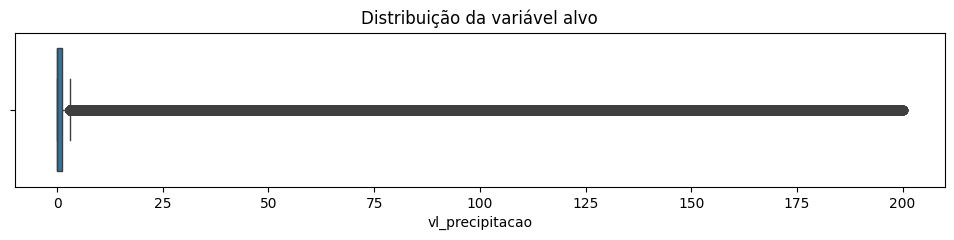

In [22]:
plt.clf()
fig = plt.figure(figsize=(12,2))
g = sns.boxplot(df_target_log['vl_precipitacao'],orient='y')
plt.title("Distribuição da variável alvo")
plt.show()

<Figure size 640x480 with 0 Axes>

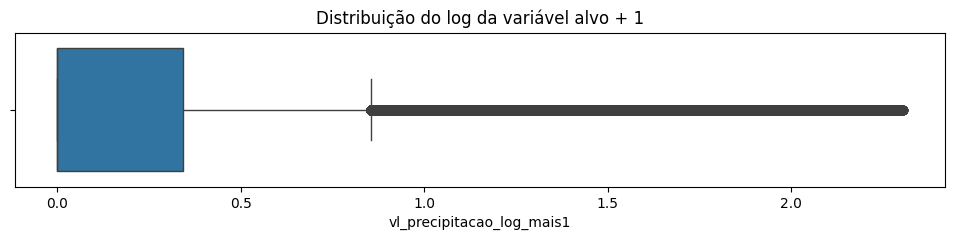

In [23]:
plt.clf()
fig = plt.figure(figsize=(12,2))
g = sns.boxplot(df_target_log['vl_precipitacao_log_mais1'],orient='y')
plt.title("Distribuição do log da variável alvo + 1")
plt.show()

# Tratamento final dos dados

In [2]:
abt_tratada = modelling_db.execute(
"""
WITH estacoes_min_medicoes AS (
SELECT
    id_estacao
FROM abt_estacoes_3_vizinhas
GROUP BY
    id_estacao
HAVING COUNT(*)>=365
)
SELECT
    abt.*
FROM abt_estacoes_3_vizinhas AS abt
INNER JOIN estacoes_min_medicoes AS emm
    ON abt.id_estacao = emm.id_estacao
WHERE 1=1
    AND NOT (
        (abt.id_estacao = '575931' AND abt.dt_medicao BETWEEN '2015-07-01' AND '2016-10-31') OR 
        (abt.id_estacao = '576368' AND abt.dt_medicao BETWEEN '2015-04-29' AND '2016-10-31') OR 
        (abt.id_estacao = '924085' AND abt.dt_medicao BETWEEN '2015-07-02' AND '2016-12-31')
)
""").fetch_df()

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

In [3]:
n_vizinhas_disponiveis = 10
for i in range(1,n_vizinhas_disponiveis+1):
    abt_tratada[f'vl_precipitacao_vizinha_fila_{i}'] = abt_tratada[f'vl_precipitacao_vizinha_{i}']
    for j in range(i+1,n_vizinhas_disponiveis+1):
        abt_tratada[f'vl_precipitacao_vizinha_fila_{i}'] = abt_tratada[f'vl_precipitacao_vizinha_fila_{i}'].fillna(abt_tratada[f'vl_precipitacao_vizinha_{j}'])

In [4]:
for i in range(1,n_vizinhas_disponiveis+1):
    print("Percentual de nulos na fila de estações vizinhas")
    print(f"> Posição {i}: {len(abt_tratada.loc[abt_tratada[f'vl_precipitacao_vizinha_fila_{i}'].isna()])*100/len(abt_tratada):.2f}%")

Percentual de nulos na fila de estações vizinhas
> Posição 1: 0.19%
Percentual de nulos na fila de estações vizinhas
> Posição 2: 0.36%
Percentual de nulos na fila de estações vizinhas
> Posição 3: 0.43%
Percentual de nulos na fila de estações vizinhas
> Posição 4: 0.50%
Percentual de nulos na fila de estações vizinhas
> Posição 5: 0.81%
Percentual de nulos na fila de estações vizinhas
> Posição 6: 1.21%
Percentual de nulos na fila de estações vizinhas
> Posição 7: 2.06%
Percentual de nulos na fila de estações vizinhas
> Posição 8: 3.79%
Percentual de nulos na fila de estações vizinhas
> Posição 9: 7.27%
Percentual de nulos na fila de estações vizinhas
> Posição 10: 20.97%


In [5]:
abt_tratada['vl_precipitacao_log'] = np.log(abt_tratada['vl_precipitacao']+1)

In [6]:
abt_tratada = abt_tratada.sort_values(by=['id_estacao','dt_medicao'])

In [7]:
abt_tratada['percentil_temporal'] = (
    abt_tratada.groupby('id_estacao').cumcount() + 1
) / abt_tratada.groupby('id_estacao')['id_estacao'].transform('count')

In [10]:
final_db.execute(
"""
CREATE OR REPLACE TABLE abt_base AS
SELECT * FROM abt_tratada
""")

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))